<a href="https://colab.research.google.com/github/Basu8971/Materraproject/blob/main/rainfall%20per%20month.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Average Precipitation by Yield Category (May-Dec 2023):
    Yield Category  Average Precipitation
0            0-100               0.000000
1            0-100               0.000000
2            0-100               0.000000
3            0-100              11.512469
4            0-100               0.000000
..             ...                    ...
931     Above 1000              38.561200
932     Above 1000               0.000000
933     Above 1000               0.000000
934     Above 1000              30.162800
935     Above 1000               0.000000

[936 rows x 2 columns]


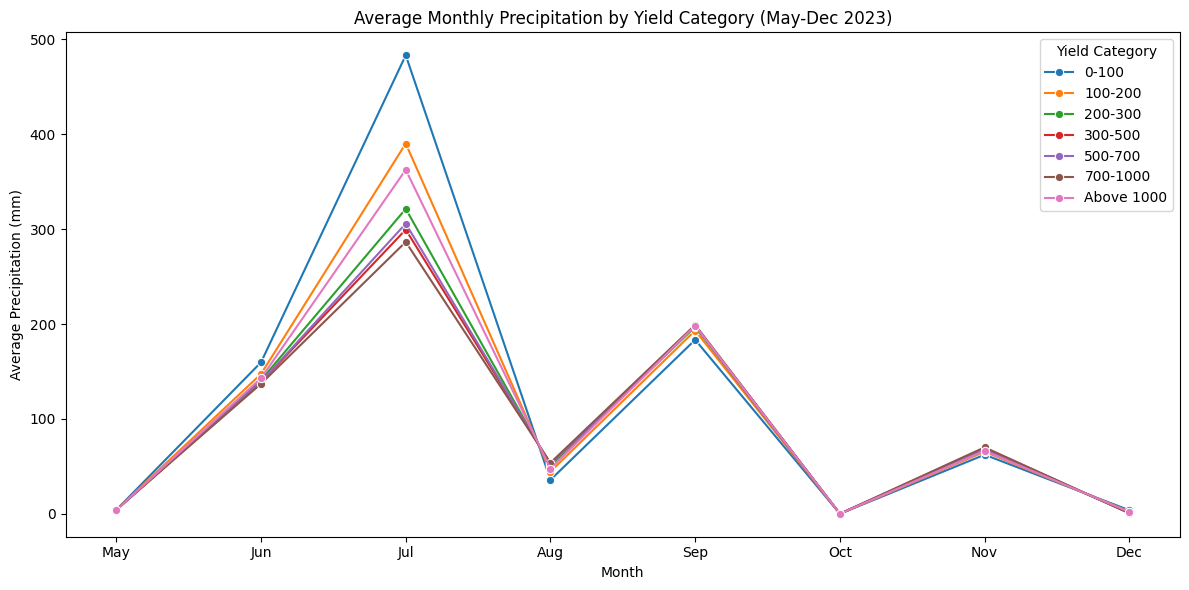

<ipython-input-7-28dbe89730db>:98: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=cumulative_precipitation_avg, x='Yield Category', y='Average Precipitation', palette='Set2')


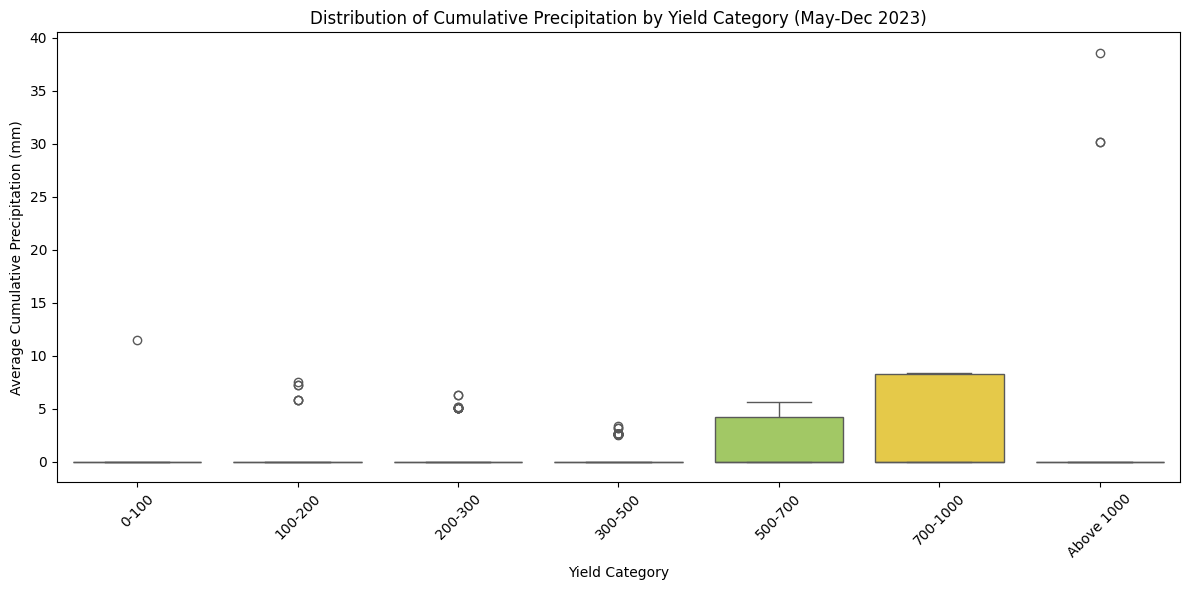

In [7]:
import pandas as pd
import gspread
from google.auth import default
from google.colab import auth
import seaborn as sns
import matplotlib.pyplot as plt

# Authenticate and access Google Sheets
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

# URLs for the Google Sheets
sheet_1_url = 'https://docs.google.com/spreadsheets/d/1hzlVvQIKfDp4J1CsZvSS1EOGqKZrihj4jm--w6QftT4/edit?gid=1261462149#gid=1261462149'  # Yield data
sheet_2_url = 'https://docs.google.com/spreadsheets/d/1SPfjZYQKwa9ImMpzTyIItqffctLy4SVJsRRgB_abIS8/edit?gid=2074528728#gid=2074528728'  # Weather data

# Load the sheets into pandas DataFrames
weather_sheet = gc.open_by_url(sheet_2_url).sheet1
yield_sheet = gc.open_by_url(sheet_1_url).sheet1

# Convert the data to pandas DataFrames
weather_data = pd.DataFrame(weather_sheet.get_all_records())
yield_data = pd.DataFrame(yield_sheet.get_all_records())

# Step 1: Clean the data and format the Date columns
yield_data['Date'] = pd.to_datetime(yield_data['DOS'], format='%d/%m/%Y')  # Use DOS (Date of Sowing) for the yield data
weather_data['Date'] = pd.to_datetime(weather_data['Date'], format='%d/%m/%Y')

# Step 2: Filter weather data for May 1st to December 30th, 2023
weather_data_filtered = weather_data[(weather_data['Date'].dt.year == 2023) &
                                      (weather_data['Date'].dt.month >= 5) &
                                      (weather_data['Date'].dt.month <= 12)]

# Step 3: Categorize farmers based on the 'Yield' column
def categorize_yield(row):
    if row > 1000:
        return 'Above 1000'
    elif row <= 100:
        return '0-100'
    elif row <= 200:
        return '100-200'
    elif row <= 300:
        return '200-300'
    elif row <= 500:
        return '300-500'
    elif row <= 700:
        return '500-700'
    elif row <= 1000:
        return '700-1000'

yield_data['Yield Category'] = yield_data['Yield'].apply(categorize_yield)

# Step 4: Merge the yield data and weather data on FarmerName
merged_data = pd.merge(yield_data[['FarmerName', 'Yield Category']],
                       weather_data_filtered[['FarmerName', 'Date', 'precipitation']],
                       on='FarmerName', how='left')

# Step 5: Extract Month and Year from the Date and calculate monthly cumulative precipitation
merged_data['Month'] = merged_data['Date'].dt.month
merged_data['Year'] = merged_data['Date'].dt.year

# Step 6: Calculate cumulative precipitation by month for each farmer
monthly_precipitation = merged_data.groupby(['FarmerName', 'Month', 'Yield Category'])['precipitation'].sum().reset_index()

# Step 7: Calculate the average precipitation by yield category for each month
avg_monthly_precipitation = monthly_precipitation.groupby(['Month', 'Yield Category'])['precipitation'].mean().reset_index()

# Step 8: Calculate cumulative precipitation from May to December for each yield category
cumulative_precipitation = merged_data.groupby(['Yield Category', 'FarmerName'])['precipitation'].sum().reset_index()

# Step 9: Calculate the number of farmers in each yield category
farmers_per_category = merged_data.groupby('Yield Category')['FarmerName'].nunique().reset_index()
farmers_per_category.rename(columns={'FarmerName': 'Number of Farmers'}, inplace=True)

# Step 10: Calculate the average precipitation by dividing total precipitation by the number of farmers
cumulative_precipitation_avg = pd.merge(cumulative_precipitation, farmers_per_category, on='Yield Category', how='left')
cumulative_precipitation_avg['Average Precipitation'] = cumulative_precipitation_avg['precipitation'] / cumulative_precipitation_avg['Number of Farmers']

# Step 11: Print the average precipitation by yield category
print("Average Precipitation by Yield Category (May-Dec 2023):")
print(cumulative_precipitation_avg[['Yield Category', 'Average Precipitation']])

# Step 12: Plot the results for the average precipitation per yield category for each month
plt.figure(figsize=(12, 6))
sns.lineplot(data=avg_monthly_precipitation, x='Month', y='precipitation', hue='Yield Category', marker='o')

# Customizing the plot
plt.title('Average Monthly Precipitation by Yield Category (May-Dec 2023)')
plt.xlabel('Month')
plt.ylabel('Average Precipitation (mm)')
plt.xticks(ticks=range(5, 13), labels=['May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Yield Category')
plt.tight_layout()
plt.show()

# Step 13: Plot the boxplot for cumulative precipitation by yield category
plt.figure(figsize=(12, 6))
sns.boxplot(data=cumulative_precipitation_avg, x='Yield Category', y='Average Precipitation', palette='Set2')

# Customizing the boxplot
plt.title('Distribution of Cumulative Precipitation by Yield Category (May-Dec 2023)')
plt.xlabel('Yield Category')
plt.ylabel('Average Cumulative Precipitation (mm)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
